## Expectation maximization demo

Check out paper @[link](https://www.nature.com/articles/nbt1406)

Assume there are two coins:
- Coin 1
- Coin 2

When tossed, probability of a head is:
- $p_1$ for coin 1
- $p_2$ for coin 2

Procedure:
1. First a coin is selected randomly.
    - Probability of selecting coin 1 is $\pi_1$
    - Probability of selecting coin 2 is $\pi_2$

2. When a coin is selected, it is tossed 10 times and results are recorded.

Steps 1 and 2 are repeated 5 times. Following data is observed:

|  Set  | Observation |
|-------|-------------|
|1|[H, T, T, T, H, H, T, H, T, H] |
|2|[H, H, H, H, T, H, H, H, H, H] |
|3|[H, T, H, H, H, H, H, T, H, H] |
|4|[H, T, H, T, T, T, H, H, T, T] |
|5|[T, H, H, H, T, H, H, H, T, H] |

Find values of $\pi_1, \pi_2, p_1, p_2$ using expectation maximization.





In [1]:
import numpy as np
import random

H = 1
T = 0

# number of coins
K= 2

# number of sets
N = 5

# number of observation per set
M = 10

# observations
observations = np.array([ [H, T, T, T, H, H, T, H, T, H], \
               [H, H, H, H, T, H, H, H, H, H], \
               [H, T, H, H, H, H, H, T, H, H], \
               [H, T, H, T, T, T, H, H, T, T], \
               [T, H, H, H, T, H, H, H, T, H] ])

Initialize:
1. Coin selection probilities as $\pi_1= 0.5$ and $\pi_2=0.5$.
2. Coin probability of head as $p_1=0,1$ and $p_2=0.5$.


In [2]:
# initial coin selection probabilities
hat_pi = np.array([0.5, 0.5])

# initial head probabilities
hat_p = np.array([0.6, 0.5])

Expection maximization algorithm has two steps in a single iteration:
1. Expectation: Find the expected values of membership function that shows which coin is selected. 
    - $z_{1i}=1$ if coin 1 is selected for set i
    - $z_{1i}=0$ if coin 1 is not selected for set i

    In this step, we will compute expected values of $z_{1i}$ and $z_{2i}$ for $i=1..5$, and fill out the table below:

| E($z_{ki}$)  | set1 | set 2 | set 3 | set 4 | set 5 | Total |
|----------------|----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| E($z_{1i}$)    |      |       |       |       |       | $N_1$ |
| E($z_{2i}$)      |      |       |       |       |       | $N_2$ |
| Total                    | 1    | 1     | 1     | 1     | 1     | $N$   |

  where 
$$
E(z_{ki})=\frac{\pi_k f_{ki}}{\sum_j \pi_j f_{ji}}
$$
  and $f_{ki}$ is the joint probability of observation $i$ if coin $k$ is tossed.
$$
f_{ki} = p_k^{H_i} (1-p_k)^{T_i}
$$
   and $H_i, T_i$ are number of heads and number of tails in observation $i$ respectively.
    


In [3]:
def joint_prob(p, obs, k, i):
    N, M = obs.shape
    H_i = np.sum(obs[i,:])
    T_i = M - H_i 

    return p[k]**H_i * (1-p[k])**T_i



def e_step(pi, p, obs):

    K = pi.shape[0]
    N, M = obs.shape

    # membership function
    exp_z = np.zeros((K,N),dtype=float)

    
    for i in range(N):
        j_prob = [hat_pi[t]*joint_prob(hat_p, obs, t, i) for t in range(K)]
        exp_z[:, i] = j_prob/np.sum(j_prob)
    
    return exp_z

# test 
exp_z = e_step(hat_pi, hat_p, observations)

2. M-step: Maximize log likelihood using expected coin selection and head probabilities

$$
N_k = \sum_i z_{ki}
$$

$$
N_k(H) = \frac{1}{M} \sum_i z_{ki}H_i
$$

Update:
$$
\pi_k = \frac{N_k}{N}
$$

$$
p_k = \frac{N_k(H)}{N_k}
$$

In [4]:
def m_step(exp_z, obs):
    K = exp_z.shape[0]
    N, M = obs.shape

    N_k = np.sum(exp_z, axis=1)
    H_i = [np.sum(obs[i,:]) for i in range(N)]
    N_k_H = np.sum( exp_z * H_i, axis=1)/M 
    
    # update parameters
    hat_pi = N_k/N 
    hat_p = N_k_H / N_k
    
    return hat_pi, hat_p
    
#test
hat_pi, hat_p = m_step(exp_z, observations)

Now, for a certain number of iterations call e-step and m-step successively.

In [5]:
hat_pi = np.array([0.5, 0.5])
hat_p = np.array([0.6, 0.5])
exp_z = np.zeros((K,N),dtype=float)

n_iter = 10

for iteration in range(n_iter):
    exp_z = e_step(hat_pi, hat_p, observations)
    hat_pi, hat_p = m_step(exp_z, observations)
    print(iteration, hat_pi, hat_p)


0 [0.59739457 0.40260543] [0.71301224 0.58133931]
1 [0.59087598 0.40912402] [0.73274531 0.55493783]
2 [0.582044 0.417956] [0.75223001 0.53156083]
3 [0.57247097 0.42752903] [0.76742179 0.51615981]
4 [0.56364558 0.43635442] [0.77711467 0.50872121]
5 [0.5561608 0.4438392] [0.78267788 0.50627624]
6 [0.55001328 0.44998672] [0.78584967 0.50617548]
7 [0.54501059 0.45498941] [0.78776968 0.50695066]
8 [0.54094464 0.45905536] [0.78903405 0.50794802]
9 [0.53763641 0.46236359] [0.78993265 0.50891431]


Log likelihood should increase with each iteration.

$$
\log L(\pi_1, \pi_2, p_1, p_2) = \Pi_i \sum_k \pi_k f_{ki}
$$

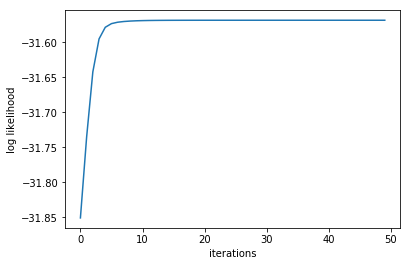

In [7]:
def log_likelihood(pi, p, obs):
    K = pi.shape[0]
    N, M = obs.shape
    
    likelihood = 1
    for i in range(N):
        likelihood *= np.sum([hat_pi[t]*joint_prob(hat_p, obs, t, i) \
             for t in range(K)])


    return np.log(likelihood)


hat_pi = np.array([0.5, 0.5])
hat_p = np.array([0.6, 0.5])
exp_z = np.zeros((K,N),dtype=float)

n_iter = 50
log_l = list()

for iteration in range(n_iter):
    exp_z = e_step(hat_pi, hat_p, observations)
    hat_pi, hat_p = m_step(exp_z, observations)
    log_l.append( log_likelihood(hat_pi, hat_p, observations) )
    # print(iteration, log_l[iteration])

import matplotlib.pyplot as plt

plt.plot(log_l)
plt.xlabel('iterations')
plt.ylabel('log likelihood');
